In [184]:
#! wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
#! tar -zxvf 101_ObjectCategories.tar.gz

In [235]:
import numpy as np
import seaborn as sns

In [186]:
from imutils import paths
import matplotlib.pyplot as plt

import numpy as np
import cv2
import os

In [213]:
LABELS = ["Faces", "Leopards", "Motorbikes", "airplanes","accordion","brain","dolphin"]

imagePaths = list(paths.list_images("101_ObjectCategories"))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (96, 96))
 
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    
print("image loaded")

image loaded


(96, 96, 3)


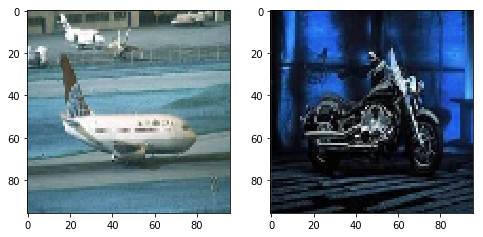

In [214]:
print(data[0].shape)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(data[123])
plt.subplot(1,2,2)
plt.imshow(data[1234])

In [215]:
data = np.array(data) / 255

In [216]:
data.shape

(2451, 96, 96, 3)

In [217]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [218]:
binarizer = LabelBinarizer()

In [219]:
labels = binarizer.fit_transform(labels)

In [220]:
from sklearn.model_selection import train_test_split

In [221]:
x_train,x_test,y_train,y_test = train_test_split(data,labels,test_size=0.3)

In [222]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dropout,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [228]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),padding="same",activation="relu"))
model.add(MaxPool2D())

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(LABELS), activation="softmax"))

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [229]:
directory = f"models/{len(LABELS)}-categories/"
if not os.path.exists(directory):
    os.makedirs(directory)

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint(directory + 'model.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

model.fit(x=x_train,y=y_train,batch_size=64,epochs=25,validation_data=(x_test,y_test),callbacks=[earlyStopping,mcp_save,reduce_lr_loss])

Train on 1715 samples, validate on 736 samples
Epoch 1/25
1715/1715 [==============================] - 21s 12ms/sample - loss: 1.2287 - acc: 0.5417 - val_loss: 0.6533 - val_acc: 0.8261
Epoch 2/25
1715/1715 [==============================] - 18s 10ms/sample - loss: 0.3815 - acc: 0.8752 - val_loss: 0.2332 - val_acc: 0.9266
Epoch 3/25
1715/1715 [==============================] - 18s 11ms/sample - loss: 0.2160 - acc: 0.9230 - val_loss: 0.1942 - val_acc: 0.9375
Epoch 4/25
1715/1715 [==============================] - 18s 10ms/sample - loss: 0.1293 - acc: 0.9580 - val_loss: 0.1220 - val_acc: 0.9579
Epoch 5/25
1715/1715 [==============================] - 18s 11ms/sample - loss: 0.0600 - acc: 0.9808 - val_loss: 0.1576 - val_acc: 0.9606
Epoch 6/25
1715/1715 [==============================] - 18s 10ms/sample - loss: 0.0609 - acc: 0.9784 - val_loss: 0.1949 - val_acc: 0.9457
Epoch 7/25
1715/1715 [==============================] - 19s 11ms/sample - loss: 0.0398 - acc: 0.9878 - val_loss: 0.1335 - val

In [230]:
model.evaluate(x=x_test,y=y_test)

736/736 [==============================] - 2s 2ms/sample - loss: 0.1601 - acc: 0.9688


[0.1601007609278895, 0.96875]

In [233]:
pred = [LABELS[p.argmax()] for p in model.predict(x_test)]

In [240]:
y_test_oneclass = [LABELS[p.argmax()] for p in y_test]

print(confusion_matrix(y_test_oneclass,pred))

print(classification_report(y_test_oneclass,pred))

[[133   0   1   0   0   0   1]
 [  0  70   0   0   0   0   0]
 [  0   0 236   0   0   1   0]
 [  0   0   1 225   0   0   1]
 [  0   0   0   0  13   1   0]
 [  5   0   2   3   1  21   1]
 [  0   0   0   5   0   0  15]]
              precision    recall  f1-score   support

       Faces       0.96      0.99      0.97       135
    Leopards       1.00      1.00      1.00        70
  Motorbikes       0.98      1.00      0.99       237
   accordion       0.97      0.99      0.98       227
   airplanes       0.93      0.93      0.93        14
       brain       0.91      0.64      0.75        33
     dolphin       0.83      0.75      0.79        20

   micro avg       0.97      0.97      0.97       736
   macro avg       0.94      0.90      0.92       736
weighted avg       0.97      0.97      0.97       736



In [ ]:
from tensorflow.keras.models import load_model

In [211]:
t_model = load_model("model.14-0.09.hdf5")

In [212]:
t_model.evaluate(x_test,y_test)

736/736 [==============================] - 2s 2ms/sample - loss: 0.0852 - acc: 0.9715


[0.08519168449160845, 0.9714674]